## 导入相关库

In [10]:
import numpy as np
import os
import matplotlib.pyplot as plt
from src.lib.utils.metric_show import *
from src.lib.utils.metrics import calculate_error


## 导入数据

### 实验路径
baseline和当前best的

In [9]:
# 0sec
exp_dir = "/root/autodl-tmp/caoxiaoyan/urbanflood/exp/"
dataset_dir = "/root/autodl-tmp/caoxiaoyan/urbanflood/data/urbanflood22/train/flood/"

location = 16
best = "20240107_223311_284164"
best_exp_dir = os.path.join(exp_dir, best,"save_res_data/epoch@999997")
key = "h" # 对比的变量
unit = 1000

# ['G1162_intensity_131', 'G3531_intensity_128', 'G1166_intensity_246', 'G1135_intensity_161']
# event_name = "G1162_intensity_131"
event_name = "r500y_p0.3_d3h"

event_dir = os.path.join(dataset_dir,f"location{location}",event_name)
save_root = os.path.join("figs",event_name)

### 加载实验结果
包括h、u、v的预测和实测值

In [11]:
# 2.5s

def load_arrays_from_npz(event_name, exp_dir, key="huv", unit=1000):
    pred_huv_save_path = os.path.join(exp_dir, f"pred_{event_name}.npz")
    label_huv_save_path = os.path.join(exp_dir, f"label_{event_name}.npz")
    # 加载.npz文件
    pred_huv = np.load(pred_huv_save_path)
    label_huv = np.load(label_huv_save_path)

    # 读取数组
    pred = []
    label = []
    for k in key:
        pred.append(np.squeeze(pred_huv["pred_%s" % k]) / unit)
        label.append(np.squeeze(label_huv["label_%s" % k]) / unit)

    return pred, label

pred, label = load_arrays_from_npz(event_name,best_exp_dir,  key=key)

## 计算

### 所有指标
```
axis=0: 得到空间的结果(500, 500)
axis=(1,2)：得到时间的结果(360,)
axis=None：得到整体结果，1个值(1,)
```

【每次评估都可以有一个值，axis=None】

像素级：MVAE（峰值误差）、MaxPAE（水深最大点的位置偏移）

图像级：MAE, MSE、SSIM（结构相似性）, PSNR（峰值信噪比）、MaxAE（误差的最大值）



【最后一次评估的时候按分钟画曲线，axis=(1,2)】

图像级：MAE, MSE、SSIM（结构相似性）, PSNR（峰值信噪比）、MaxAE（误差的最大值）、MVAE（峰值误差）



【给一幅图,axis=0】

图像级：MAE, MSE、MaxAE（误差的最大值，所在二维空间的散点密度图）、 MVAE（峰值误差）、MTAE（达峰时刻偏移误差）

#### 指标计算

##### 点、空间、时序的各项指标值

In [12]:
# 17.4s
results = {"best":pred}

metric_results={}
for name,val in results.items():
    metric_results[name] = {}
    for i, k in enumerate(key):
        point = calculate_error(val[i], label[i], axis=None)
        space =calculate_error(val[i], label[i], axis=0)
        series = calculate_error(val[i], label[i], axis=(1, 2))
        k_dict = {"point":point,
                  "space":space,
                  "series":series,
                  }
        metric_results[name][k] =k_dict
print(metric_results)

{'best': {'h': {'point': {'MaxVAE': 0.006341934, 'MaxTAE': None, 'MaxPAE': None, 'MAE': 0.0015180507, 'RMSE': 0.0067528645, 'SSIM': 0.9970515434331926, 'PSNR': 52.61479159545908, 'FDAE': None}, 'space': {'MaxVAE': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00479077, 0.00455287,
        0.00106511],
       [0.        , 0.        , 0.        , ..., 0.00185443, 0.0026353 ,
        0.00043061],
       [0.        , 0.        , 0.        , ..., 0.00467359, 0.00526638,
        0.00521985]], dtype=float32), 'MaxTAE': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 

##### 获取最大误差时刻和对应的值

In [126]:
# 0.6s
results = {"best":pred}

AE_results={}
for name,val in results.items():
    AE_results[name] = {}
    for i, k in enumerate(key):
        max_error_timestep = cal_max_error_position(val[i],label[i])
        e = cal_Error(val[i][max_error_timestep], label[i][max_error_timestep])
        k_dict = {"error":e,
                  "frame":max_error_timestep,
                  "pred":val[i][max_error_timestep], 
                  "label":label[i][max_error_timestep],
                  }
        AE_results[name][k] =k_dict

## 可视化分析

### 降雨可视化

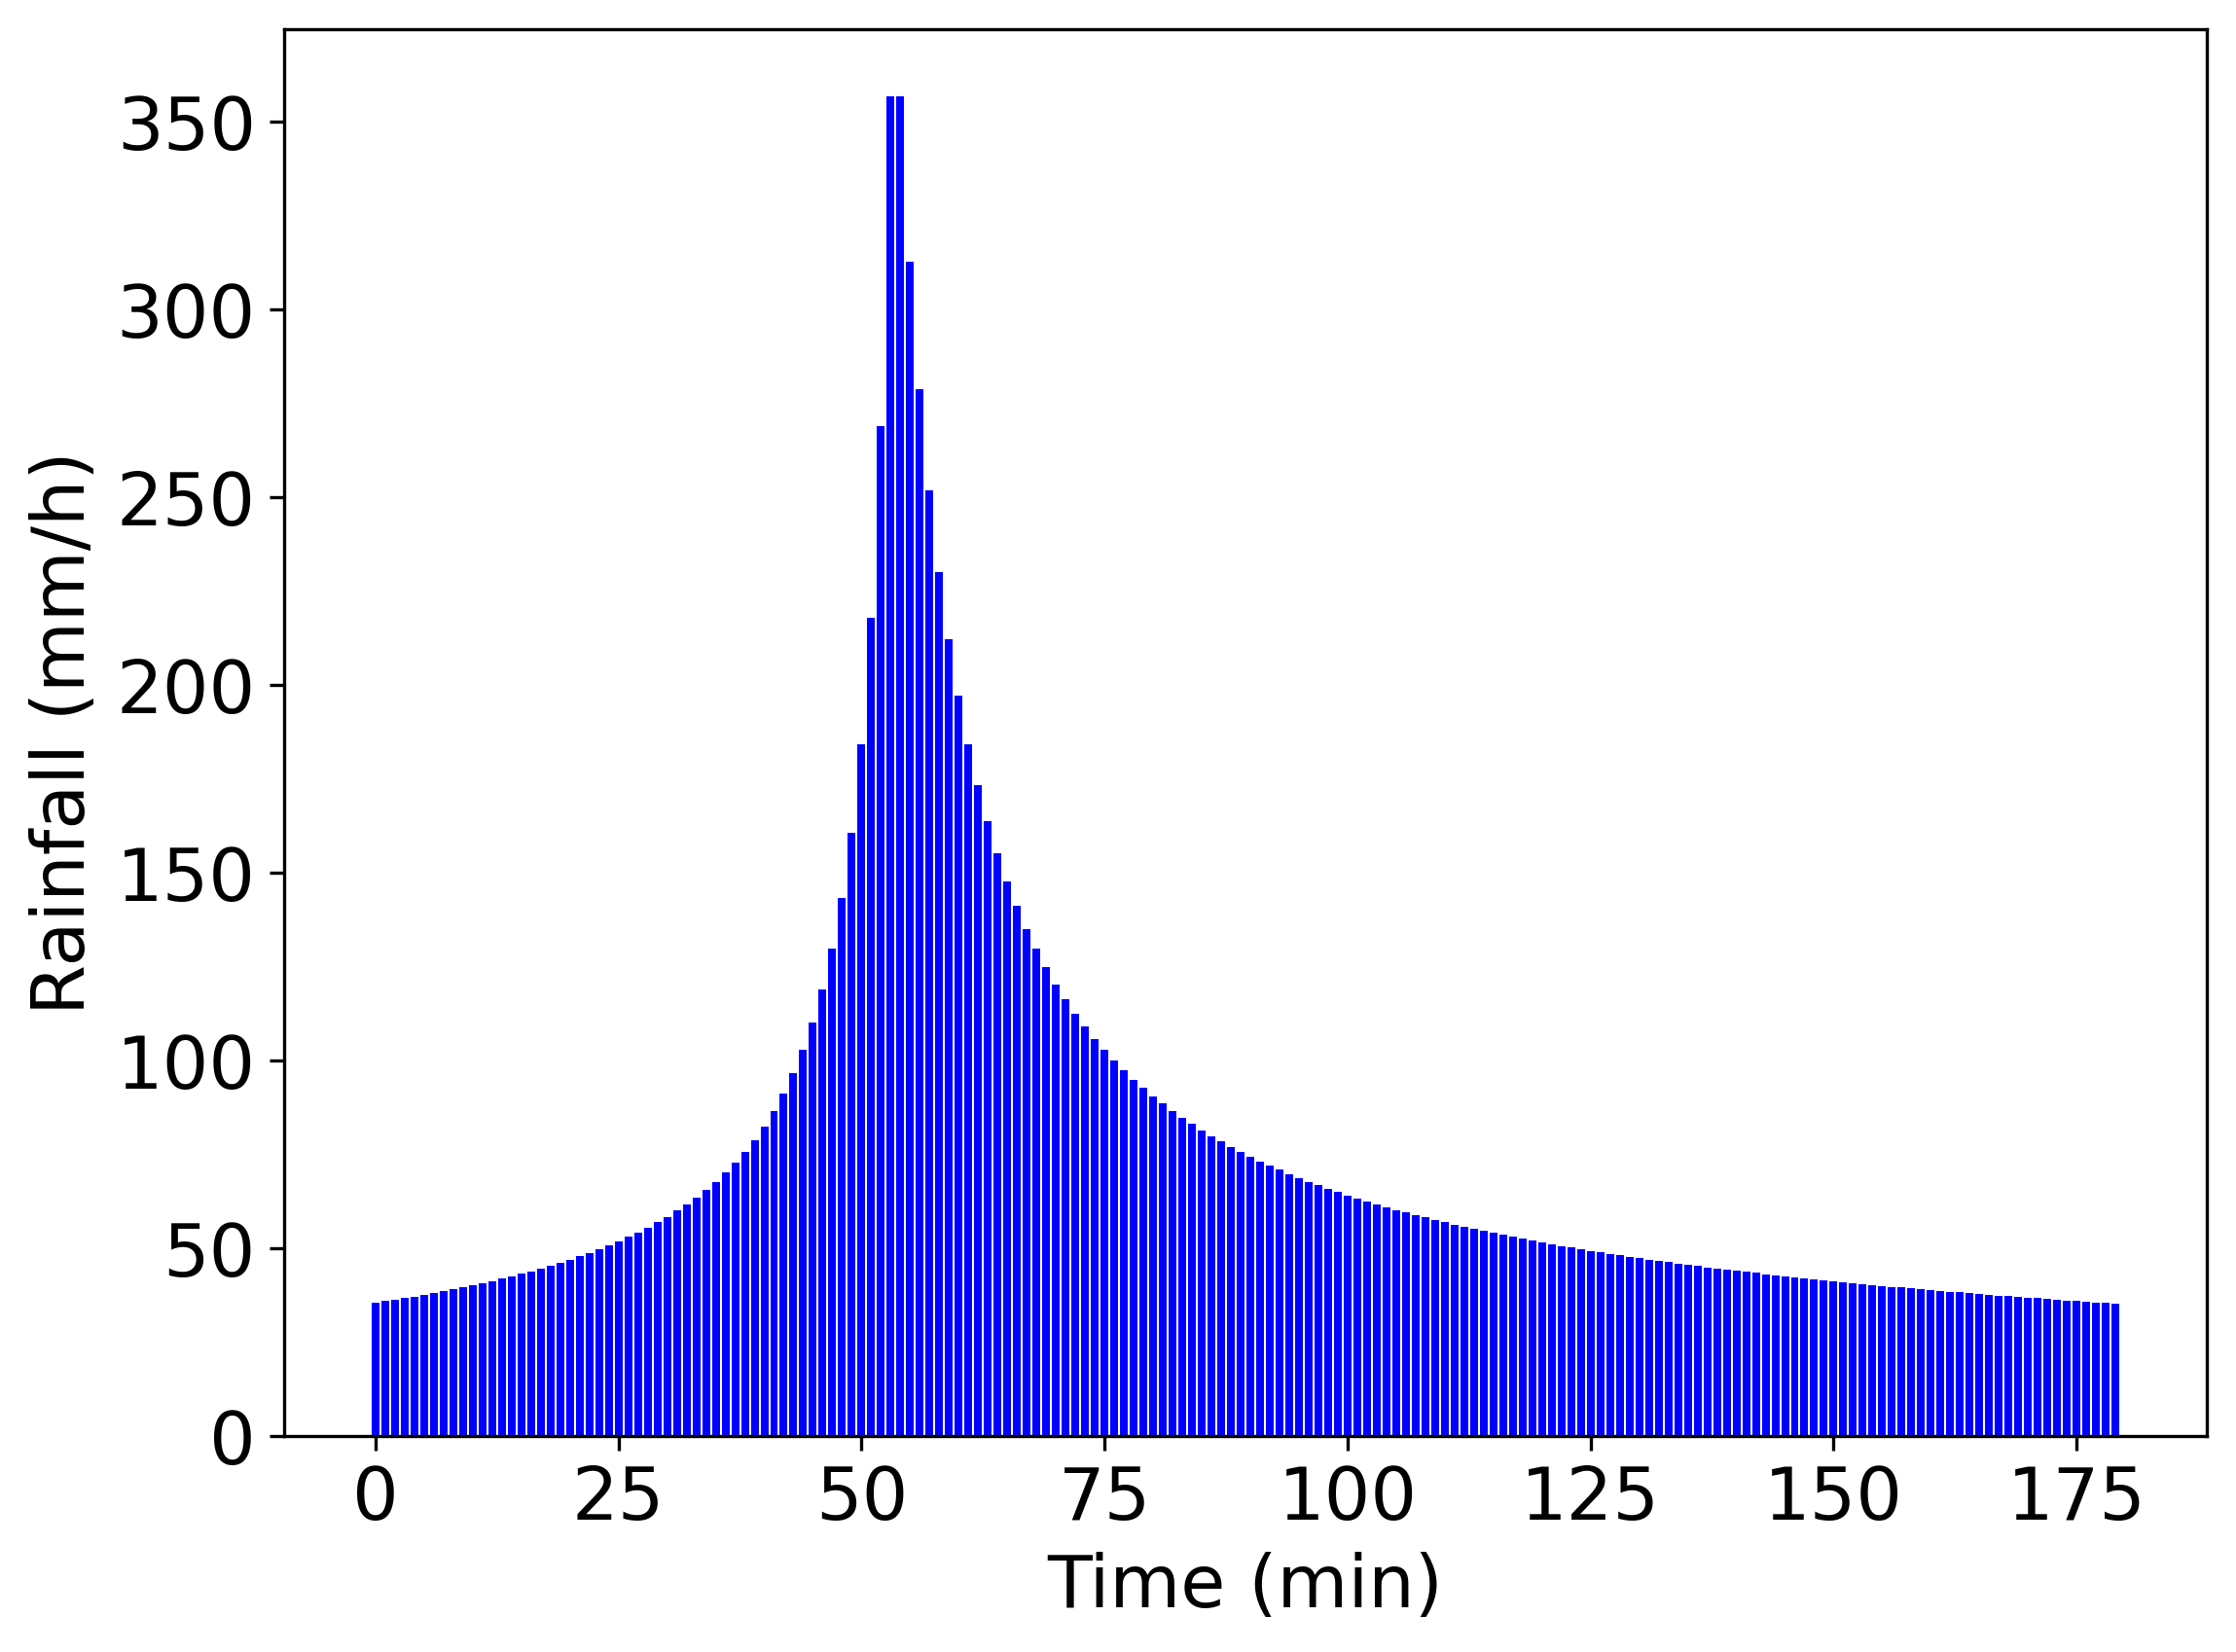

In [158]:
def plot_rainfall(rainfall):
    """
    Plot the rainfall time series data.

    :param rainfall: A numpy array of rainfall data with shape (180,).
    """
    plt.figure(figsize=(8, 6),dpi=300)
    # plt.plot(rainfall, color='blue')
    xx = range(len(rainfall))
    plt.bar(xx,rainfall, color='b')
    # plt.title('Rainfall Time Series', fontsize=14)
    plt.xlabel('Time (min)', fontsize=18)
    plt.ylabel('Rainfall (mm/h)', fontsize=18)
    # plt.grid(True)
    plt.tight_layout()
    plt.show()
    
rainfall_path = os.path.join(event_dir,"rainfall.npy")
rainfall = np.load(rainfall_path)

plot_rainfall(rainfall*60)

### 最大误差时刻

In [13]:
# 1.1s
save_dir = os.path.join(save_root, "vis_metrics/max_error")
if not os.path.exists(save_dir):
    os.makedirs(save_dir,exist_ok=True)

for name,val in results.items():
    for i, k in enumerate(key):
        pred_ = AE_results[name][k]["pred"]
        label_ = AE_results[name][k]["label"]
        error = AE_results[name][k]["error"]
        frame = AE_results[name][k]["frame"]
        vis_error(pred_, label_, error,
                  key=name+"_"+k, unit="m",
                  frame=frame, cmap = plt.cm.Set1,save_dir=save_dir)

ab_error: [0.00,0.80]
error: [-0.80,0.24]


### 逐分钟误差值
【最后一次评估的时候按分钟画曲线，axis=(1,2)】

图像级：MAE, MSE、SSIM（结构相似性）, PSNR（峰值信噪比）、MaxAE（误差的最大值）、MVAE（峰值误差）

In [14]:
save_dir = os.path.join(save_root, "vis_metrics/series-train")
if not os.path.exists(save_dir):
    os.makedirs(save_dir,exist_ok=True)

metric_names = list(metric_results[list(metric_results.keys())[0]]["h"]["series"].keys())
print(metric_names)
for i, k in enumerate(key): # 变量
    for m in metric_names: # 指标
        key_metric = []
        for name,val in metric_results.items(): # 实验
            name_k_m_series = metric_results[name][k]["series"][m]
            if name_k_m_series is None:
                continue
            key_metric.append(name_k_m_series)
        if len(key_metric):
            vis_vs_mean_std(key_metric,  mean=None, std=None,
                            name=k+"-"+m, save_dir=save_dir, data_type=["best"],fontsize=20)

['MaxVAE', 'MaxTAE', 'MaxPAE', 'MAE', 'RMSE', 'SSIM', 'PSNR', 'FDAE']


<Figure size 800x1200 with 0 Axes>

<Figure size 800x1200 with 0 Axes>

<Figure size 800x1200 with 0 Axes>

<Figure size 800x1200 with 0 Axes>

<Figure size 800x1200 with 0 Axes>

<Figure size 800x1200 with 0 Axes>

#### 水深过程线（随机选取）

4


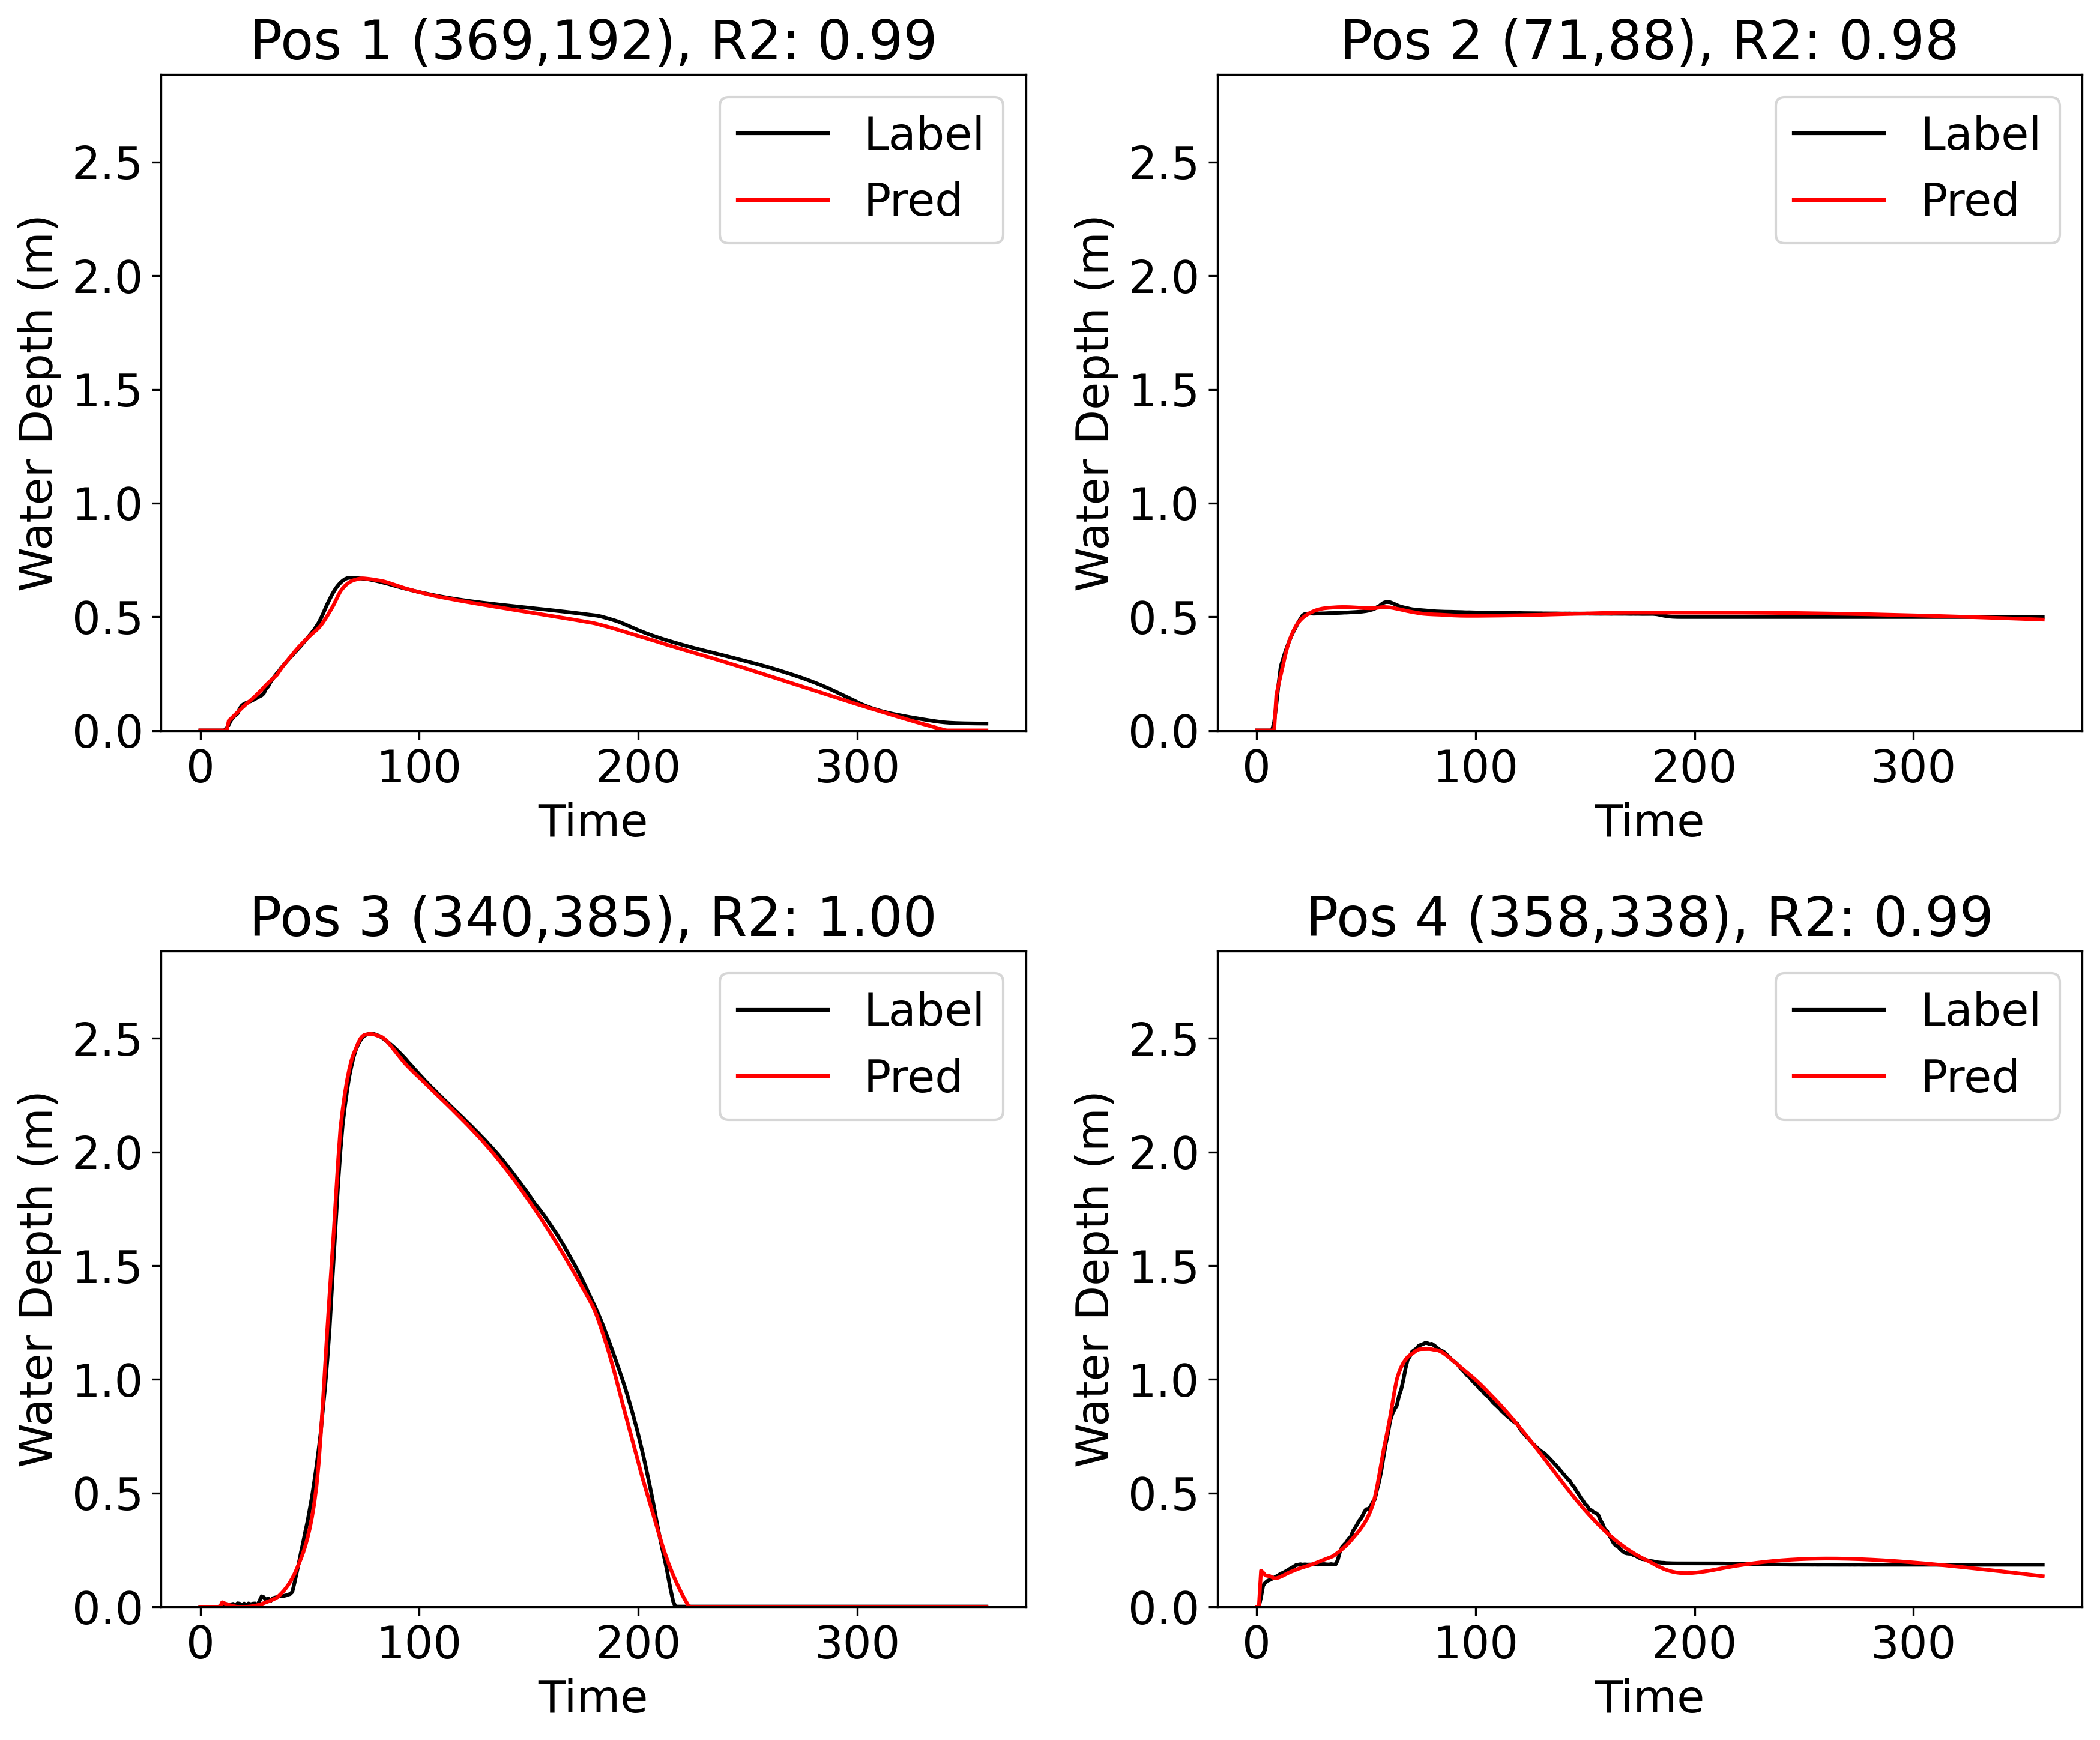

max dem:35.0


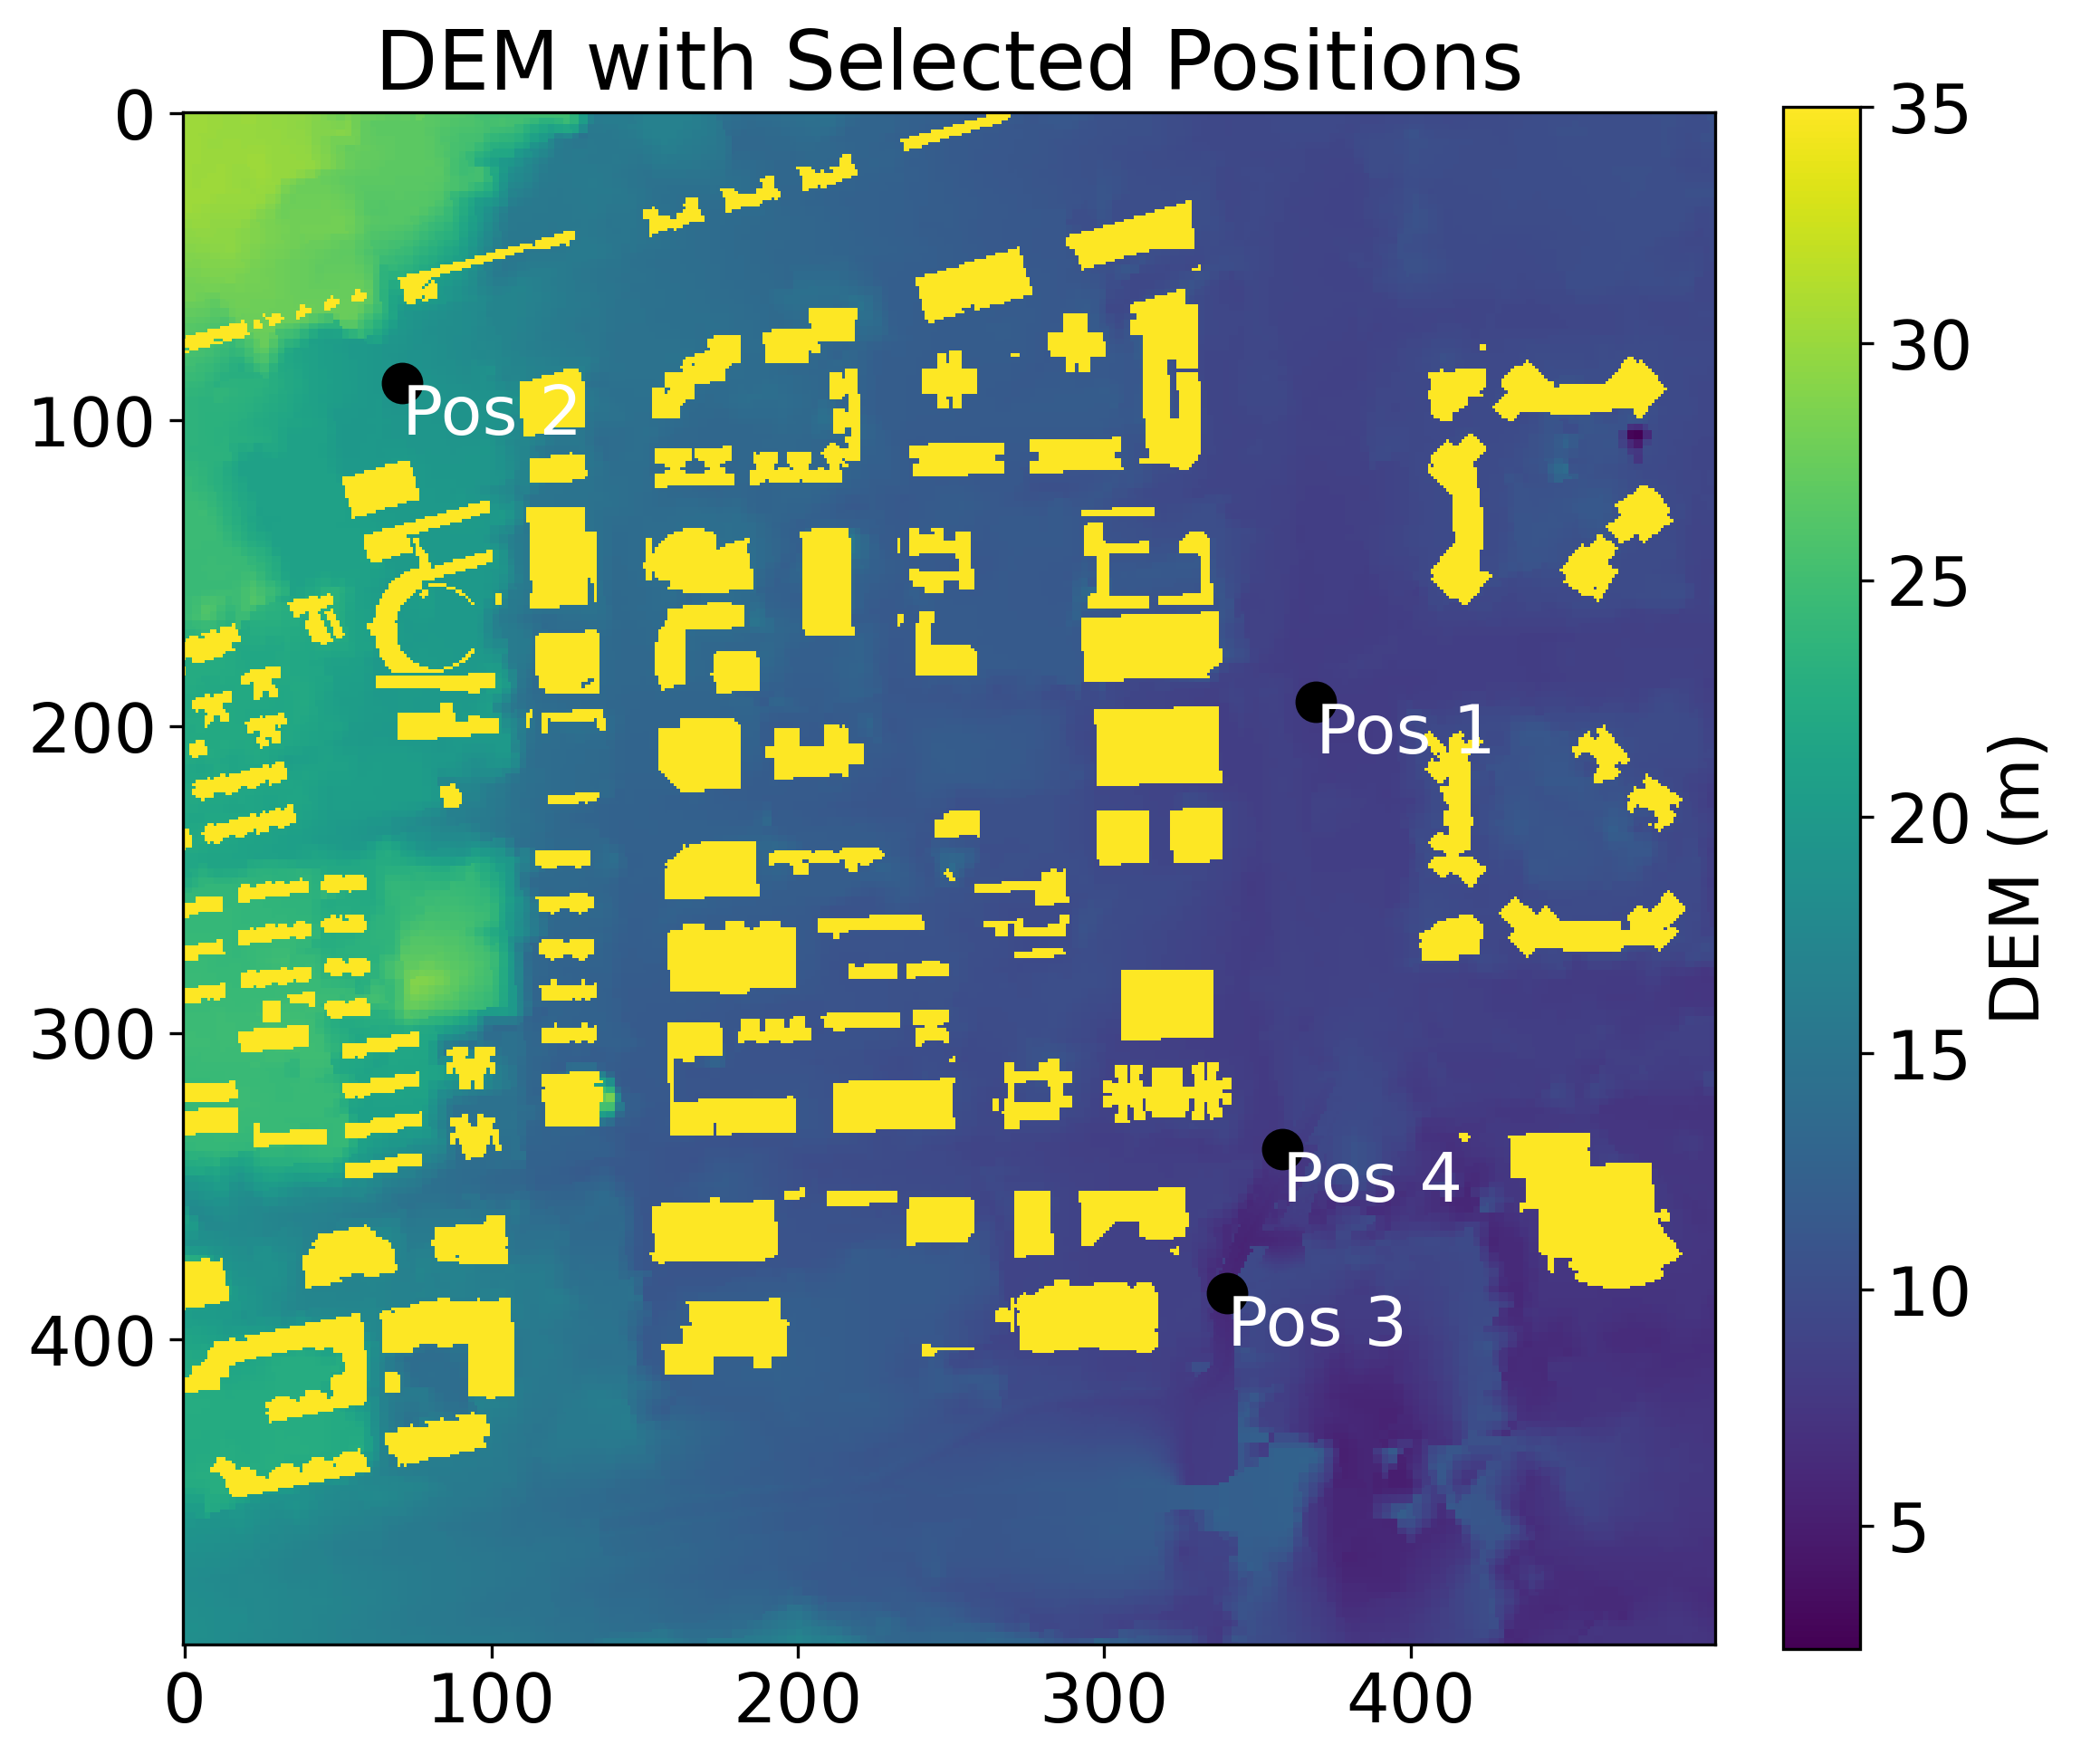

Pos 1(0, 192, 369): MAE=0.01901446096599102; MaxTAE=6.0, PeakAE=0.020427942276000977
Pos 2(0, 88, 71): MAE=0.011302223429083824; MaxTAE=2.0, PeakAE=0.02281886339187622
Pos 3(0, 385, 340): MAE=0.021146167069673538; MaxTAE=0.0, PeakAE=0.0026772022247314453
Pos 4(0, 338, 358): MAE=0.021609166637063026; MaxTAE=1.0, PeakAE=0.02656567096710205
avg MAE=0.018268004059791565; avg MaxTAE=2.25


In [136]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import r2_score


def cal_peak_ae(pred_curve, label_curve):
    # Find the index of the maximum value in label_curve
    max_value_index = np.argmax(label_curve)

    # Calculate the error at the index of the maximum value in label_curve
    error_at_max = np.abs(label_curve[max_value_index] - pred_curve[max_value_index])

    return error_at_max

    
def cal_MAE(pred, label, axis,threshold):
    flood_locations = np.any(label >= threshold, axis=0)
    label_ = label[:, flood_locations]
    pred_ = pred[:, flood_locations]
    return np.mean(np.abs(pred_ - label_), axis)


def cal_max_time_AE(pred, label,axis=0,threshold=0.15):
    """
    计算每个空间位置在T维度的最大数值的时间差（峰值时刻误差）。

    参数:
    pred (numpy.ndarray): 预测值，形状为 (T, H, W) 的输入矩阵。
    label (numpy.ndarray): 标签值，形状为 (T, H, W) 的输入矩阵。

    返回:
    peak_timing_error (numpy.ndarray): 形状为 (H, W) 的矩阵，每个位置包含该位置的峰值时刻误差。
    """
    # 找到每个空间位置在T维度的最大值的索引
    pred_max_indices = np.argmax(pred, axis=axis)
    label_max_indices = np.argmax(label, axis=axis)

    # 计算峰值时刻误差
    peak_timing_error = np.abs(pred_max_indices - label_max_indices)
    
    flood_locations = np.any(label >= threshold, axis=0)
    peak_timing_error = peak_timing_error[flood_locations]

    return np.mean(peak_timing_error)

# Function to plot the water depth curves for selected positions and DEM with selected positions marked
def plot_selected_positions_and_curves(pred, label, selected_positions):
    T, W, H = pred.shape
    
    vmax = max(label.max(),pred.max())
    vmin = min(label.min(),pred.min())
    # Plot the water depth for the selected positions
    fig, axes = plt.subplots(2, 2, figsize=(12, 10),dpi=300)
    for i, pos in enumerate(selected_positions):
        t, w, h = pos
        label_curve = label[:, w, h]
        pred_curve = pred[:, w, h]

        r2 = r2_score(label_curve, pred_curve)  # Calculate R2 score

        ax = axes[i // 2, i % 2]
        ax.plot(label_curve, c='black', label='Label')
        ax.plot(pred_curve, 'r-', label='Pred')
        ax.set_title(f'Pos {i+1} ({h},{w}), R2: {r2:.2f}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Water Depth (m)')
        
        ax.set_ylim([0, vmax])
        ax.legend()

    plt.tight_layout()
    plt.show()
    
def plot_dem_with_pos(DEM,selected_positions):
    # Plot DEM heatmap and mark the selected positions
    plt.figure(figsize=(8, 8),dpi=300)
    print(f"max dem:{DEM.max()}")
    for i, (t, w, h) in enumerate(selected_positions):
        plt.scatter(h, w, color='black', s=100)  # Mark selected position
        plt.text(h, w, f'Pos {i+1}', color='white', ha='left', va='top')
    im = plt.imshow(DEM)

    # Create colorbar with a size matching the image
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label('DEM (m)')
    
    plt.title('DEM with Selected Positions')
    plt.tight_layout()
    plt.show()


np.random.seed(10)
pred_h = pred[0] # T,W,H
label_h = label[0] # T,W,H
T, W, H = pred_h.shape

dem_path = "/root/autodl-tmp/caoxiaoyan/urbanflood/data/urbanflood22/train/geodata/location16/absolute_DEM.npy"
DEM = np.load(dem_path)


# 1. 随机选取label中水深超过0.5m的N个不同空间位置（空间距离不能太近）
N = 4  # 选择4个位置
threshold = 0.3  # 水深阈值

# 2. 随机选择N个位置
# 3. 筛选满足阈值的位置
# valid_positions = np.argwhere(label_h >= threshold)
# selected_indices = np.random.choice(len(valid_positions), N, replace=False)
# selected_positions = [tuple(valid_positions[i]) for i in selected_indices]
# selected_positions = []
# for i in range(300,340):
#     for j in range(300,380):
#         if np.any(label_h[:, i, j] > 0.5):
#             selected_positions.append((0,i,j))
selected_positions = [(0,192,369),(0,88,71), (0,385,340),(0,338,358)]
print(len(selected_positions))

# 4. 画出这N个不同空间位置的水深曲线，label为绿色，pred为红色
plot_selected_positions_and_curves(pred_h, label_h, selected_positions)
plot_dem_with_pos(DEM,selected_positions)

# 5. 统计点的情况
mae_list = []
maxtae_list = []
for i, pos in enumerate(selected_positions):
    t, w, h = pos
    label_curve = label_h[:, w, h]
    pred_curve = pred_h[:, w, h]
    
    mae = cal_MAE(pred_curve, label_curve, axis=None,threshold=0)
    maxtae = cal_max_time_AE(pred_curve, label_curve,axis=0,threshold=0.15)
    peakae = cal_peak_ae(pred_curve, label_curve)
    print(f"Pos {i+1}{pos}: MAE={mae}; MaxTAE={maxtae}, PeakAE={peakae}")
    
    mae_list.append(mae)
    maxtae_list.append(maxtae)
    
    

print(f"avg MAE={np.mean(mae_list)}; avg MaxTAE={np.mean(maxtae_list)}")

### 空间误差值

【给一幅图,axis=0】

图像级：MAE, MSE、MaxAE（误差的最大值，所在二维空间的散点密度图）、 MVAE（峰值误差）、MTAE（达峰时刻偏移误差）
、CSI

#### 回归

In [20]:
# 1.3s
def vs_visualize_metric_space(data_list, name, key_list, vmax, vmin, save_dir):
    n = len(data_list)
    # 创建图形布局
    fig, axs = plt.subplots(1, n, figsize=(6 * n, 6))
    fig.subplots_adjust(wspace=0.2)  # 调整子图间的间距

    for i in range(n):
        # 绘制第一个子图
        im1 = axs.imshow(data_list[i], cmap="bwr", vmin=vmin, vmax=vmax)
        axs.set_title(key_list[i])
        # im1 = axs[i].imshow(data_list[i], cmap="bwr", vmin=vmin, vmax=vmax)
        # axs[i].set_title(key_list[i])

    # 添加共享的颜色条
    cbar = fig.colorbar(im1, ax=axs, location="right", shrink=0.7)
    cbar.set_label(name)

    # # 设置图形标题
    # plt.suptitle(metric_name1 + " vs " + metric_name2 + " - " + key)

    # 保存图像
    save_path = os.path.join(save_dir, "vs_%s.png" % (name))
    plt.savefig(save_path, dpi=100)
    plt.close()


save_dir = os.path.join(save_root, "vis_metrics/train-space")
if not os.path.exists(save_dir):
    os.makedirs(save_dir,exist_ok=True)

metric_names = list(metric_results[list(metric_results.keys())[0]]["h"]["space"].keys())
print(metric_names)

for i, k in enumerate(key): # 变量
    for m in metric_names: # 指标
        key_metric = []
        exp_list=[]
        vmax = -999
        vmin = 999
        for name,val in metric_results.items(): # 实验
            name_k_m_series = metric_results[name][k]["space"][m]
            if name_k_m_series is None:
                break
            key_metric.append(name_k_m_series)
            if vmax < np.max(name_k_m_series):
                vmax = np.max(name_k_m_series)
            if vmin > np.min(name_k_m_series):
                vmin =np.min(name_k_m_series)
            
            exp_list.append(name)
        if len(key_metric):
            vs_visualize_metric_space(key_metric, k+"-"+m, 
                                      exp_list, vmax, vmin, save_dir)

['MaxVAE', 'MaxTAE', 'MaxPAE', 'MAE', 'RMSE', 'SSIM', 'PSNR', 'FDAE']


##### 峰值水深

1.3568


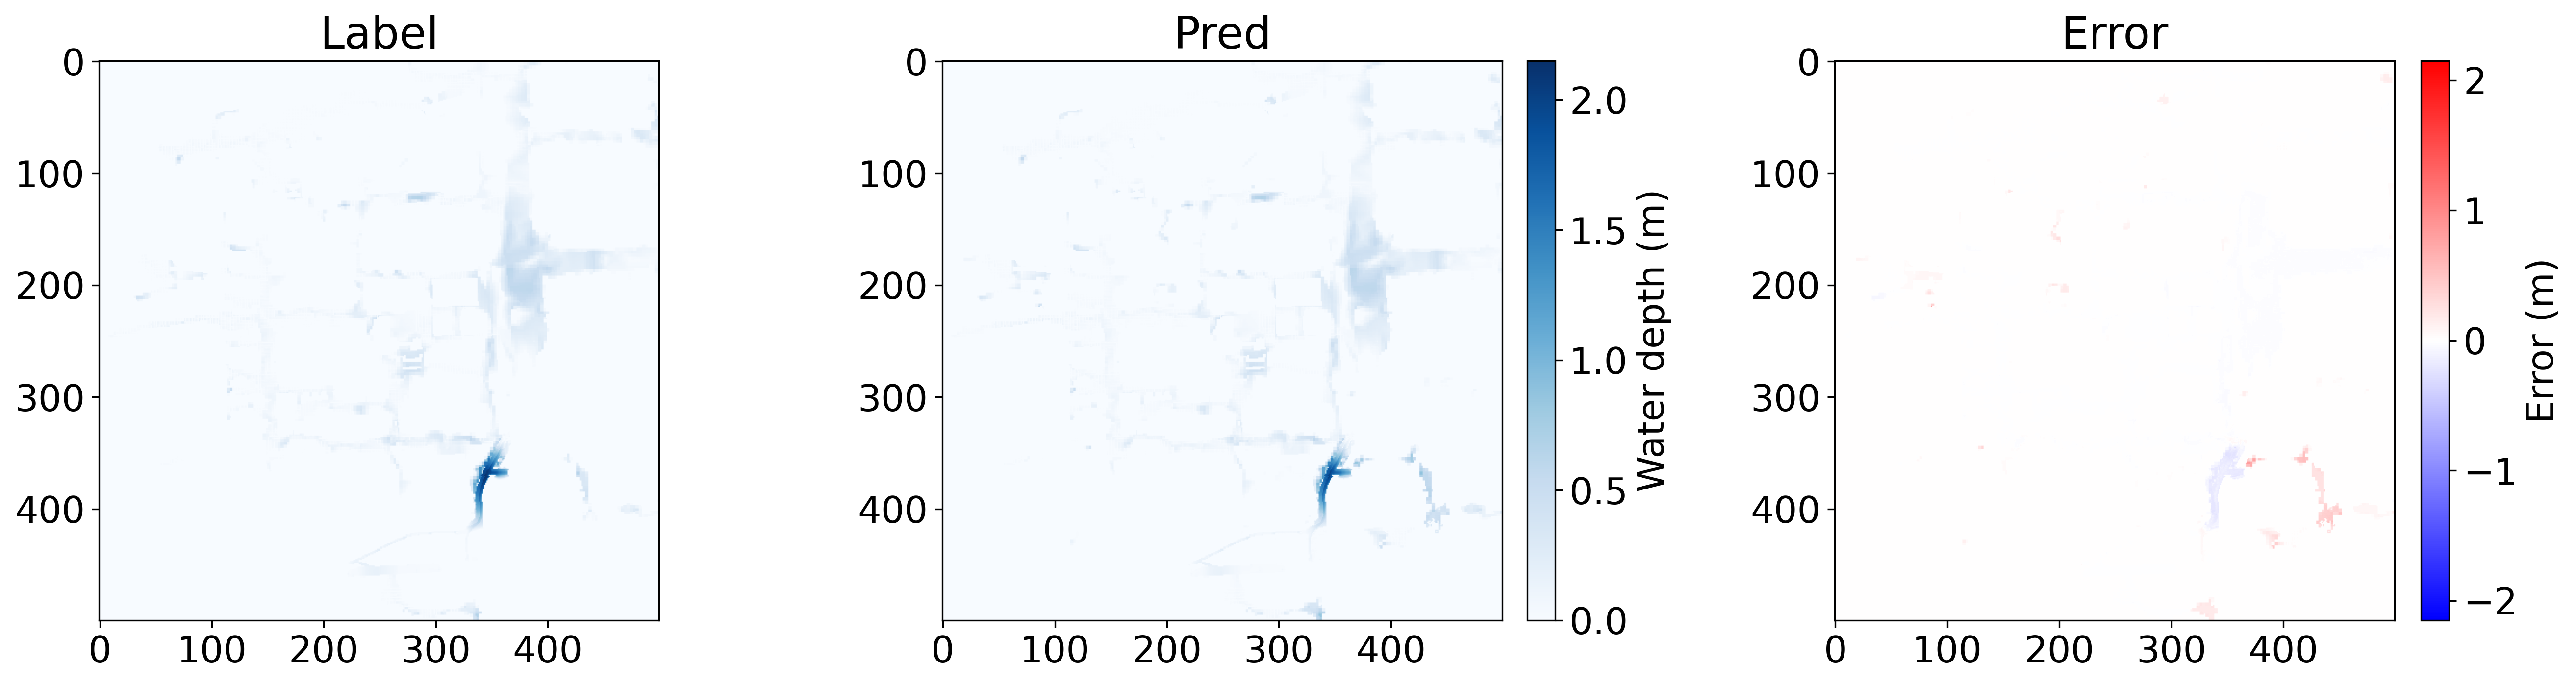

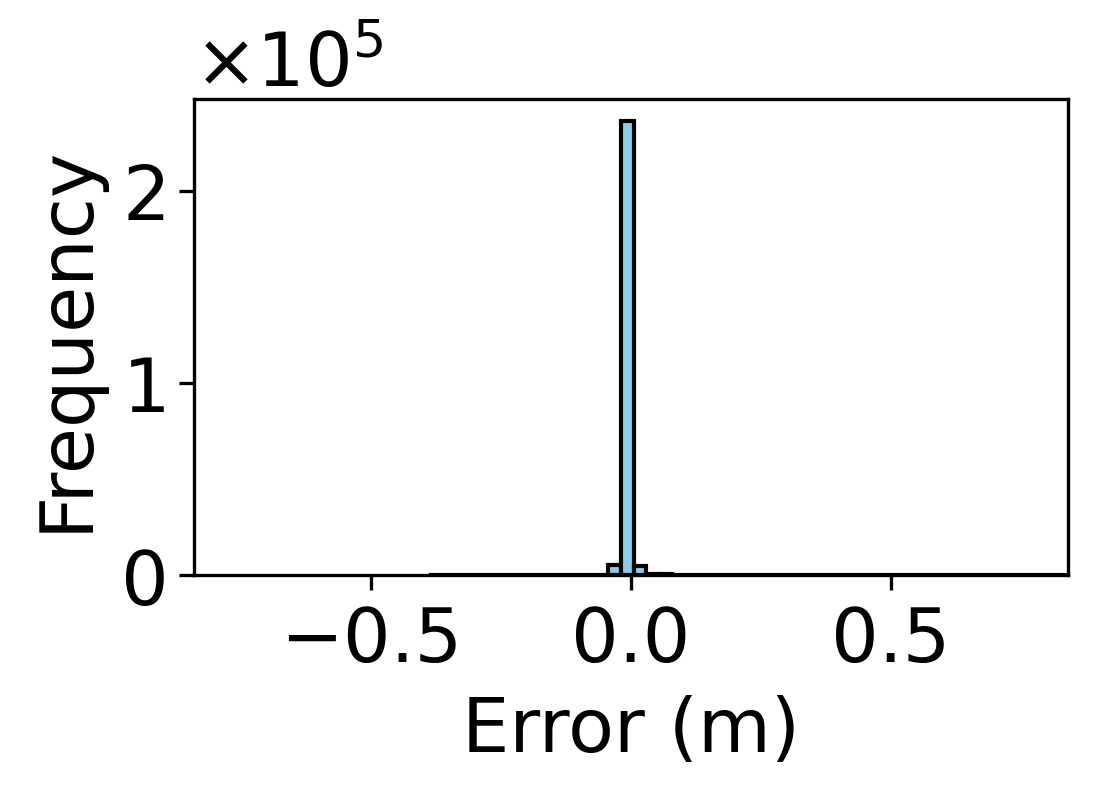

In [177]:
# 19.7s
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_density_scatter(label_max_h, pred_max_h, threshold=0.001):
    # plt.figure(dpi=300)
    # 获取非零的数据点
    label_max_h_ = label_max_h[label_max_h >= threshold]
    pred_max_h_ = pred_max_h[label_max_h >= threshold]

    # 计算点密度
    xy = np.vstack([label_max_h_, pred_max_h_])
    z = gaussian_kde(xy)(xy)

    # 根据密度对点进行排序，最密集的点在最后绘制
    idx = z.argsort()
    label_max_h_, pred_max_h_, z = label_max_h_[idx], pred_max_h_[idx], z[idx]

    fig, ax = plt.subplots(figsize=(7, 5))

    # 绘制密度散点图
    custom_color = (104/255, 123/255, 195/255)
    scatter = ax.scatter(label_max_h_, pred_max_h_, marker='o', c=z, s=5, cmap="jet") # Spectral_r

    # 创建色条图例
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(scatter, cax=cax, label='Density')

    # 绘制对角线
    max_value = max(label_max_h_.max(), pred_max_h_.max())
    ax.plot([0, max_value], [0, max_value], color='grey', ls='--', lw=1)
    
    # 设置坐标轴范围
    extent = [min(label_max_h_.min(), pred_max_h_.min()), max(label_max_h_.max(), pred_max_h_.max()),
              min(label_max_h_.min(), pred_max_h_.min()), max(label_max_h_.max(), pred_max_h_.max())]
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    # 添加标签和标题
    ax.set_xlabel('Label Max Water Depth (m)')
    ax.set_ylabel('Pred Max Water Depth (m)')

    # 计算R^2值
    r2 = r2_score(label_max_h_, pred_max_h_)

    # 添加R^2值到图的正上方
    ax.text(0.5, 1.05, f'$R^2$ = {r2:.3f}', fontsize=12, ha='center', transform=ax.transAxes)

    # 显示图形
    plt.show()


def plot_heatmaps(label_max_h, pred_max_h):    
    # Calculate the difference
    diff = pred_max_h - label_max_h

    # Determine the shared vmax and vmin for the first two heatmaps
    vmax = max(label_max_h.max(), pred_max_h.max())
    vmin = min(label_max_h.min(), pred_max_h.min())

    # Create a figure and a set of subplots with increased DPI for better quality
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'width_ratios': [1, 1, 1.05]}, dpi=300)

    # Increase the overall font size
    plt.rcParams.update({'font.size': 18})

    # First heatmap for label_max_h
    im_label = axes[0].imshow(label_max_h, cmap='Blues', vmin=vmin, vmax=vmax)
    axes[0].set_title('Label')

    # Second heatmap for pred_max_h
    im_pred = axes[1].imshow(pred_max_h, cmap='Blues', vmin=vmin, vmax=vmax)
    axes[1].set_title('Pred')

    # Third heatmap for the difference
    im_diff = axes[2].imshow(diff, cmap='bwr', vmin=-vmax, vmax=vmax)
    axes[2].set_title('Error')
    
    # Colorbar for the first two heatmaps, placed to the right of subplot 2
    cbar = fig.colorbar(im_pred, ax=axes[1], fraction=0.046, pad=0.04)
    cbar.set_label('Water depth (m)')

    # Colorbar for the third heatmap
    cbar_diff = fig.colorbar(im_diff, ax=axes[2], fraction=0.046, pad=0.04)
    cbar_diff.set_label('Error (m)')

    # Remove space between subplots
    plt.subplots_adjust(wspace=0.2)

    # Adjust layout to fit colorbars
    plt.tight_layout()
    plt.show()

def calculate_error_proportion(label_matrix, pred_matrix, threshold=0.3):
    """
    Calculate the proportion of absolute error values between two matrices that exceed a given threshold.
    
    :param label_matrix: The ground truth matrix.
    :param pred_matrix: The predicted matrix.
    :param threshold: The threshold for counting errors. Defaults to 0.3.
    :return: Proportion of values where the absolute error exceeds the threshold.
    """
    # Calculate the absolute error
    absolute_error = np.abs(pred_matrix - label_matrix)

    # Count the number of errors above the threshold
    errors_above_threshold = np.sum(absolute_error > threshold)

    # Calculate the proportion of errors above the threshold
    proportion_above_threshold = errors_above_threshold / absolute_error.size * 100

    return proportion_above_threshold

def plot_error_distribution(label_matrix, pred_matrix, bins=50):
    """
    Calculate the error between two matrices and plot the frequency distribution of the errors as a histogram.
    
    :param label_matrix: The ground truth matrix.
    :param pred_matrix: The predicted matrix.
    :param bins: The number of bins for the histogram.
    """
    # Calculate the error
    error = pred_matrix - label_matrix

    vmax = max(error.max(), abs(error.min()))
    # Plot the error distribution as a histogram
    plt.figure(figsize=(4, 3),dpi=300)
    counts, _, patches = plt.hist(error.flatten(), bins=bins, color='skyblue', edgecolor='black')

    # Set the y-axis to scientific notation
    # plt.yscale('log')
    plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
    plt.gca().ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    plt.xlim([-vmax, vmax])

    
    # Adding titles and labels
    # plt.title('Error Distribution')
    plt.xlabel('Error (m)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()



pred_h = pred[0] # T,W,H
label_h = label[0] # T,W,H

# 计算每个空间位置在T维度上的最大值
pred_max_h = np.max(pred_h, axis=0) # 在T维度上取最大值
label_max_h = np.max(label_h, axis=0) # 在T维度上取最大值

error_proportion = calculate_error_proportion(label_max_h, pred_max_h,threshold=0.05)
print(error_proportion)

# 对比图
plot_heatmaps(label_max_h, pred_max_h)
# 频率分布直方图
plot_error_distribution(label_max_h, pred_max_h)
# 散点回归图
threshold=0.001 # 0来计算R2会有很大误差
plot_density_scatter(label_max_h, pred_max_h,threshold)

#### 分类

binary_pred_h:[0 1]
binary_label_h:[0 1]


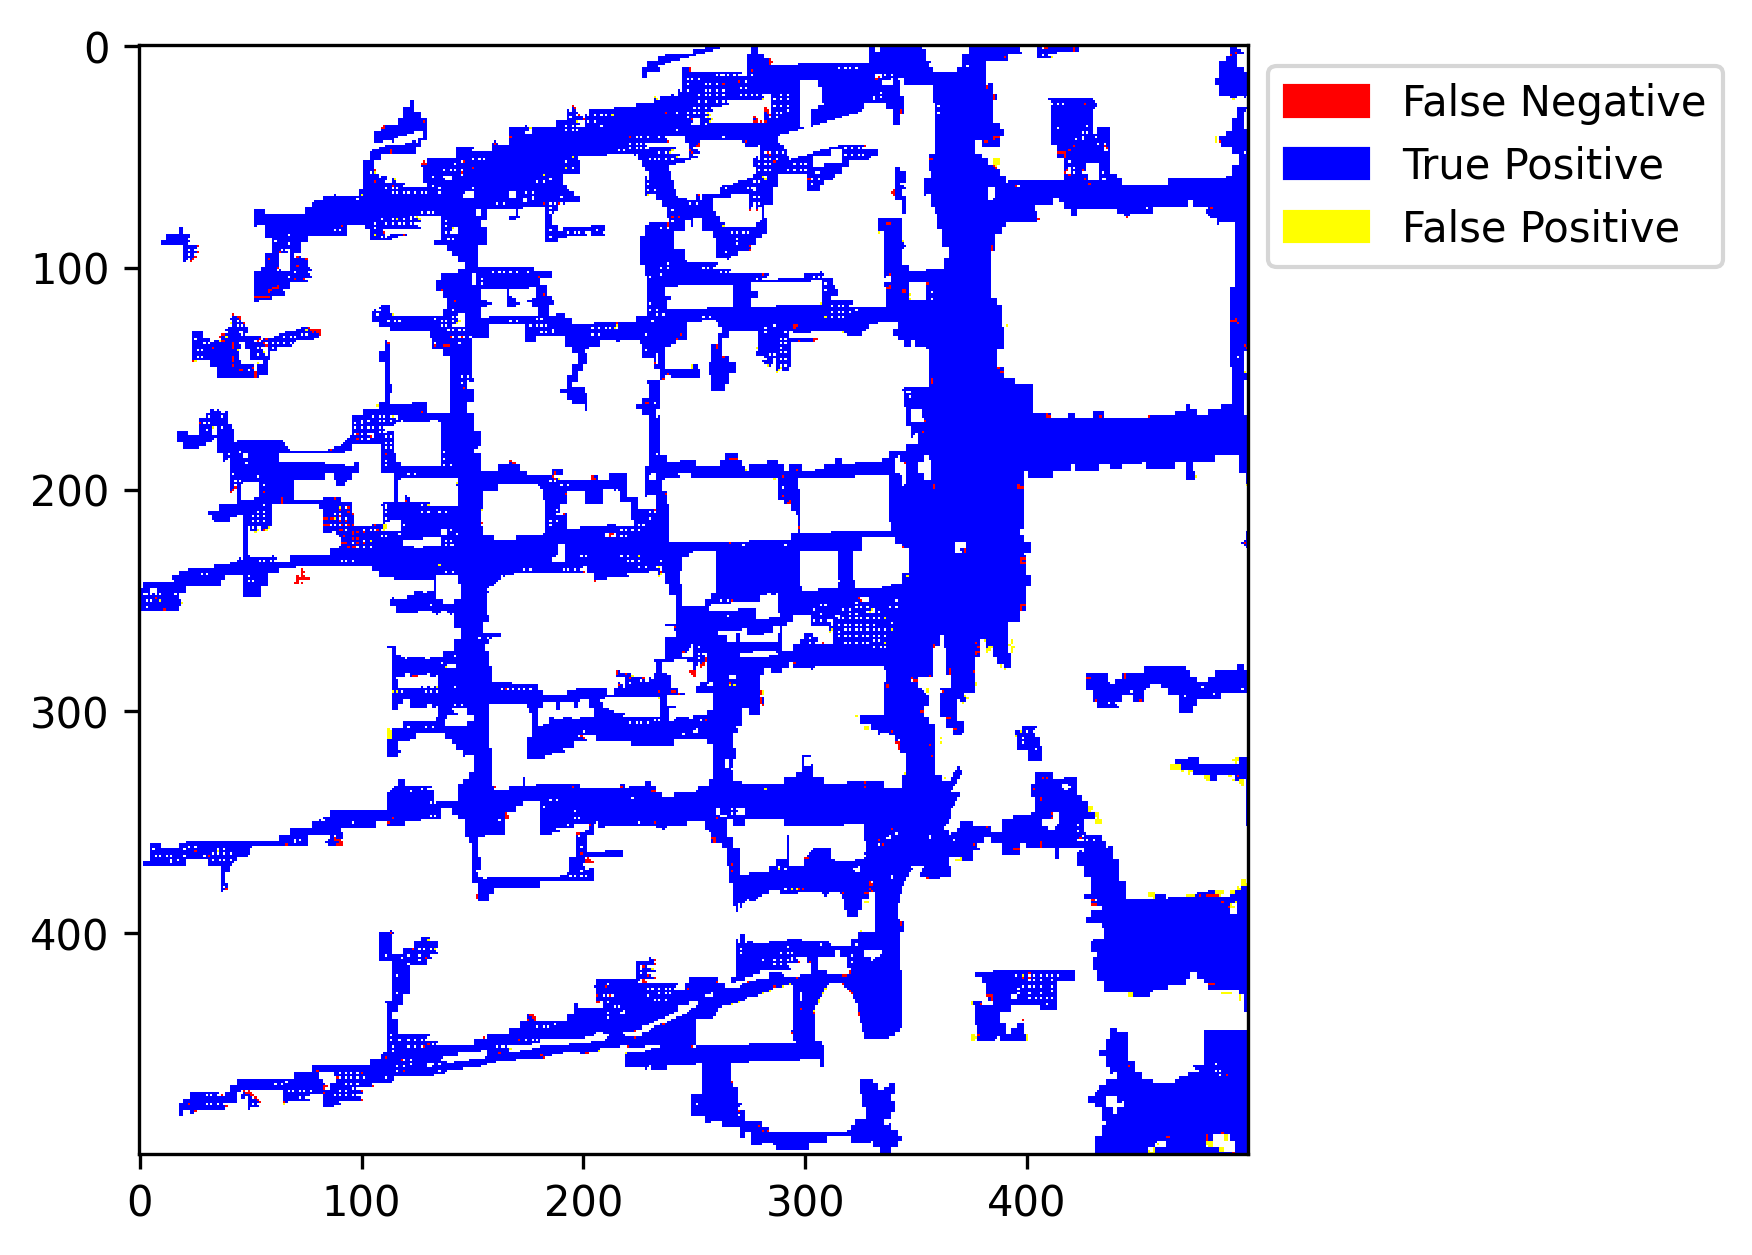

CSI:0.9871906620684427


(-0.5, 499.5, 499.5, -0.5)

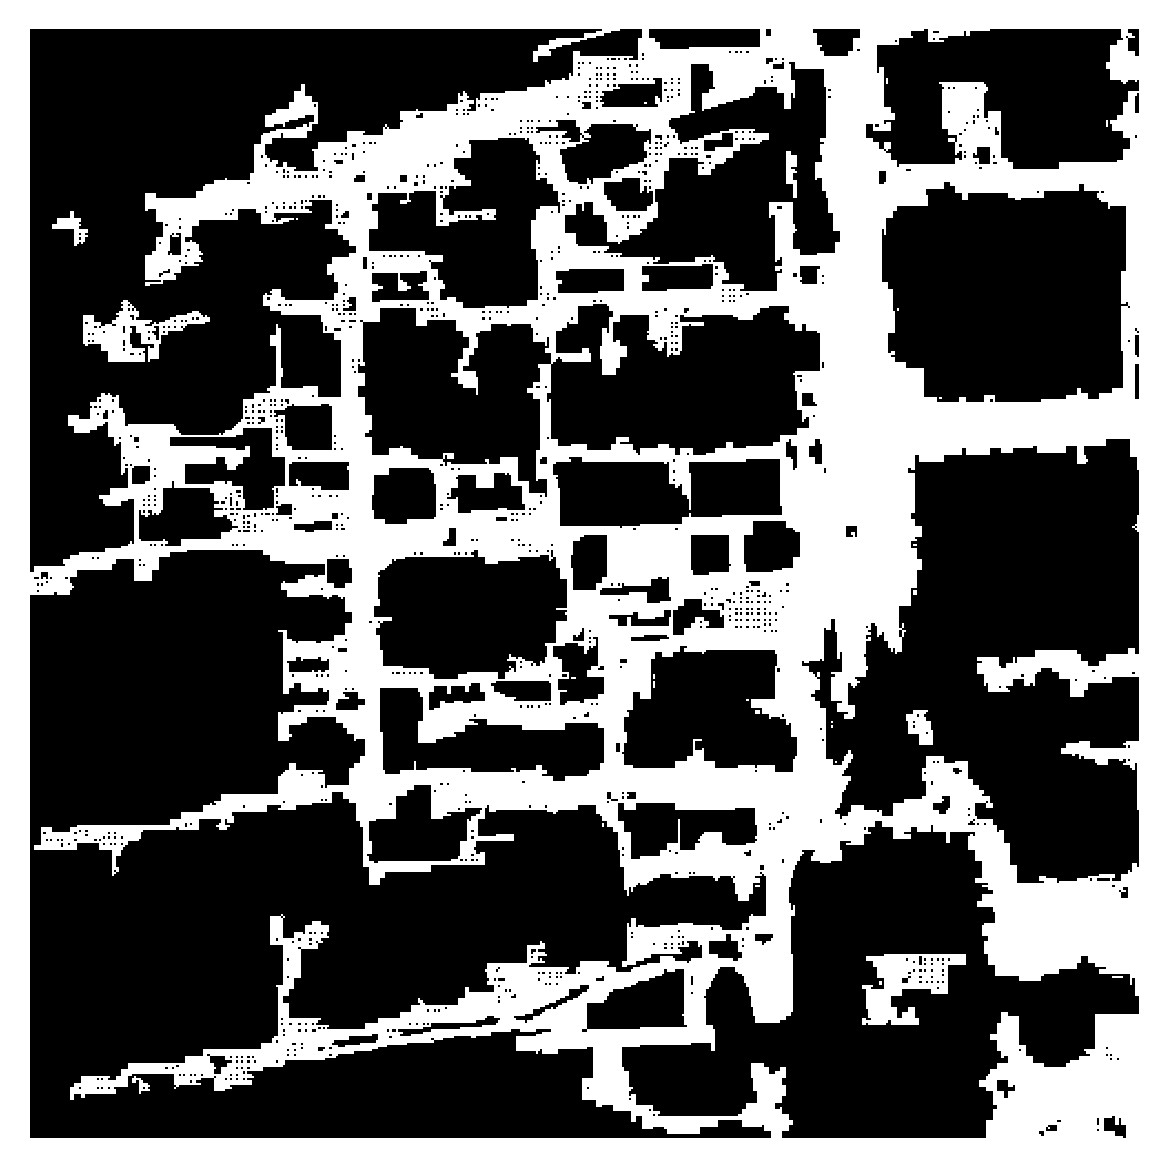

In [15]:
import matplotlib.patches as mpatches


def plot_marked_space(marked_space):
    plt.figure(dpi=300)
    # 创建颜色映射，使用红色、蓝色、黄色和白色
    cmap = plt.cm.colors.ListedColormap(['red', 'blue', 'yellow', 'white'])
    
    # 定义图例项的标签和颜色
    legend_labels = ['False Negative', 'True Positive', 'False Positive']
    legend_colors = ['red', 'blue', 'yellow', ]
    
    # 创建图例对象
    legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
    
    # 绘制标记结果
    plt.imshow(marked_space, cmap=cmap, interpolation='nearest')
    
    # 添加图例，指定位置和外侧
    plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1))
    
    # 显示图形
    plt.show()

def calculate_csi(pred, label,threshold = 0.001):
    """
    计算Critical Success Index (CSI)

    参数:
    tp (int): True Positives的数量
    fn (int): False Negatives的数量
    fp (int): False Positives的数量

    返回:
    float: CSI的值
    """
    
    # 计算每个空间位置在T维度上是否存在大于threshold的数值
    pred = np.any(pred > threshold, axis=0).astype(int)
    label = np.any(label > threshold, axis=0).astype(int)
    # CSI
    tp = np.sum((pred == 1) & (label == 1)) # 计算 TP
    fn = np.sum((pred == 0) & (label == 1)) # 计算 FN
    fp = np.sum((pred == 1) & (label == 0)) # 计算 FP

    if tp + fn + fp == 0:
        return 0  # 避免除以零的情况
    else:
        return tp / (tp + fn + fp)



# ============================================
pred_h = pred[0] # T,W,H
label_h = label[0] # T,W,H
threshold = 0.001

# 计算每个空间位置在T维度上是否存在大于threshold的数值
binary_pred_h = np.any(pred_h > threshold, axis=0).astype(int)
binary_label_h = np.any(label_h > threshold, axis=0).astype(int)

print(f"binary_pred_h:{np.unique(binary_pred_h)}")
print(f"binary_label_h:{np.unique(binary_label_h)}")
# 创建一个空间来存储标记结果
marked_space = np.zeros_like(binary_label_h)

# 标记结果：1表示正确预测，0表示漏预测，2表示虚报
marked_space[(binary_pred_h == 1) & (binary_label_h == 1)] = 1 # 正确预测
marked_space[(binary_pred_h == 0) & (binary_label_h == 1)] = 0 # 漏预测
marked_space[(binary_pred_h == 1) & (binary_label_h == 0)] = 2 # 虚报
marked_space[(binary_pred_h == 0) & (binary_label_h == 0)] = 3 # 无内涝
# print(np.unique(marked_space))

# 调用函数绘制标记结果        
plot_marked_space(marked_space)

    
csi_value = calculate_csi(pred_h, label_h,threshold=threshold) # 计算CSI
print(f"CSI:{csi_value}")


# # 画分类结果图（黑白）
# plt.figure(dpi=300)
# cmap = plt.cm.colors.ListedColormap(['black', 'white'])
# plt.imshow(binary_pred_h, cmap=cmap, interpolation='nearest')
# plt.axis("off")

### 动态误差

In [ ]:
# 3min2sec
save_dir = os.path.join(save_root, "vis_metrics/dynamic")
if not os.path.exists(save_dir):
    os.makedirs(save_dir,exist_ok=True)

for i, k in enumerate("h"):
    create_animation(pred[i], label[i], key="baseline_%s" % k,interval=50, save_dir=save_dir)

# 整体量化结果

In [16]:
# 3min
from tqdm import tqdm
from vis_metrics import ModelEvaluation
import concurrent.futures


def cal_peak_r2(pred, label,threshold):
    pred_max = np.max(pred, axis=0) # 在T维度上取最大值
    label_max = np.max(label, axis=0) # 在T维度上取最大值
    
    label_max_h_ = label_max[label_max > threshold]
    pred_max_h_ = pred_max[label_max > threshold]

    # 计算点密度
    xy = np.vstack([label_max_h_, pred_max_h_])
    z = gaussian_kde(xy)(xy)

    # 根据密度对点进行排序，最密集的点在最后绘制
    idx = z.argsort()
    label_max_h_, pred_max_h_, z = label_max_h_[idx], pred_max_h_[idx], z[idx]
    
    r2 = r2_score(label_max_h_, pred_max_h_)
    # print(f"peak r2 :{r2}")
    return r2
    
def calculate_csi(pred, label,threshold = 0.15):
    """
    计算Critical Success Index (CSI)

    参数:
    tp (int): True Positives的数量
    fn (int): False Negatives的数量
    fp (int): False Positives的数量

    返回:
    float: CSI的值
    """
    
    # 计算每个空间位置在T维度上是否存在大于threshold的数值
    pred_binary = np.any(pred > threshold, axis=0).astype(int)
    label_binary = np.any(label > threshold, axis=0).astype(int)
    # CSI
    tp = np.sum((pred_binary == 1) & (label_binary == 1)) # 计算 TP
    fn = np.sum((pred_binary == 0) & (label_binary == 1)) # 计算 FN
    fp = np.sum((pred_binary == 1) & (label_binary == 0)) # 计算 FP

    if tp + fn + fp == 0:
        return 0  # 避免除以零的情况
    else:
        return tp / (tp + fn + fp)


def cal_max_value_AE(pred, label, axis,threshold=0.15):
    space = np.abs(np.max(pred, axis) - np.max(label, axis))
    
    flood_locations = np.any(label >= threshold, axis=0)
    space = space[flood_locations]
    return np.mean(space)

def cal_max_time_AE(pred, label,axis=0,threshold=0.15):
    """
    计算每个空间位置在T维度的最大数值的时间差（峰值时刻误差）。

    参数:
    pred (numpy.ndarray): 预测值，形状为 (T, H, W) 的输入矩阵。
    label (numpy.ndarray): 标签值，形状为 (T, H, W) 的输入矩阵。

    返回:
    peak_timing_error (numpy.ndarray): 形状为 (H, W) 的矩阵，每个位置包含该位置的峰值时刻误差。
    """
    # 找到每个空间位置在T维度的最大值的索引
    pred_max_indices = np.argmax(pred, axis=axis)
    label_max_indices = np.argmax(label, axis=axis)

    # 计算峰值时刻误差
    peak_timing_error = np.abs(pred_max_indices - label_max_indices)
    
    flood_locations = np.any(label >= threshold, axis=0)
    peak_timing_error = peak_timing_error[flood_locations]

    return np.mean(peak_timing_error)

def cal_max_position_AE(pred, label,threshold):
    """
    计算pred和label在每个时刻的峰值位置的欧式距离。
    :param pred: 预测矩阵，形状为(T, H, W)
    :param label: 标签矩阵，形状为(T, H, W)
    :return: 每个时刻峰值位置的欧式距离列表
    """
    distances = []
    for t in range(pred.shape[0]):
        # 找到每个矩阵在时刻t的峰值位置
        pred_peak_pos = np.unravel_index(np.argmax(pred[t]), pred[t].shape)
        label_peak_pos = np.unravel_index(np.argmax(label[t]), label[t].shape)

        label_max = np.max(label[t])

        if label_max > threshold:
            # 找到每个矩阵在时刻t的峰值位置
            pred_peak_pos = np.unravel_index(np.argmax(pred[t]), pred[t].shape)
            label_peak_pos = np.unravel_index(np.argmax(label[t]), label[t].shape)

            # 计算欧式距离
            distance = np.linalg.norm(np.array(pred_peak_pos) - np.array(label_peak_pos))
        else:
            distance = 0

        distances.append(distance)

    return np.mean(distances)


def cal_MAE(pred, label, axis,threshold):
    flood_locations = np.any(label >= threshold, axis=0)
    label_ = label[:, flood_locations]
    pred_ = pred[:, flood_locations]
    return np.mean(np.abs(pred_ - label_), axis)


def calculate_duration_error(pred, label, threshold=0.15, min_duration=30, time_interval=1):
    """
    计算预测和实际数据中大于指定阈值的持续时间误差，并计算平均误差。
    :param pred: 预测矩阵，形状为(T, H, W)
    :param label: 实际矩阵，形状为(T, H, W)
    :param threshold: 内涝判定阈值（默认0.15米）
    :param min_duration: 最小持续时间（分钟）（默认30分钟）
    :param time_interval: 时间间隔（分钟）（默认1分钟）
    :return: 所有位置的平均持续时间误差
    """
    def calculate_duration(matrix):
        """
        计算大于阈值的持续时间
        :param matrix: 输入矩阵，形状为(T, H, W)
        :return: 每个空间位置的持续时间，形状为(H, W)
        """
        # 生成大于阈值的布尔矩阵
        greater_than_threshold = (matrix >= 0.15).astype(int)

        # 计算累积和
        cumsum = np.cumsum(greater_than_threshold, axis=0)

        # 重置累积和的值
        reset_points = np.roll(greater_than_threshold, shift=1, axis=0)
        reset_points[0, :, :] = 0  # 确保第一个时间点不被重置
        cumsum_reset = np.cumsum(greater_than_threshold * (greater_than_threshold - reset_points < 0), axis=0)

        # 计算持续时间
        duration = cumsum - cumsum_reset

        # 获取最后一个时间点的持续时间作为每个空间位置的持续时长
        duration_at_last_time_point = duration[-1, :, :]

        return duration_at_last_time_point

    pred_duration = calculate_duration(pred)
    label_duration = calculate_duration(label)

    # 计算持续时间差
    duration_error = np.abs(pred_duration - label_duration) * time_interval

    # 计算平均误差
    # 沿着时间维度判断是否存在大于阈值的数值
    flood_locations = np.any(label >= threshold, axis=0)
    average_error = np.mean(duration_error[flood_locations])
    # average_error = np.mean(duration_error)

    return average_error


def cal_metrics(pred, label,threshold=0.15):
    errors = {}
    
    # 峰值误差
    errors["MaxVAE"] = cal_max_value_AE(pred, label, axis=0,threshold=threshold)

    # 每个位置的峰值时间偏移
    errors["MaxTAE"] = cal_max_time_AE(pred, label, axis=0,threshold=threshold)

    # # 最值点的位置偏移
    # errors["MaxPAE"] = cal_max_position_AE(pred, label,threshold=threshold)

    # MAE
    errors["MAE"] = cal_MAE(pred, label, axis=None,threshold=threshold)

    # 内涝持续时长绝对误差（Flood Duration A Error）
    errors["FDAE"] = calculate_duration_error(pred, label,threshold=threshold)

    # CSI
    errors["CSI"] = calculate_csi(pred, label,threshold)
    
    # peak r2
    errors["PeakR2"] = cal_peak_r2(pred, label,threshold)
    
    
    return errors
    
def calculate_mean_std(values_dict):
    """计算给定字典中每个指标的平均值和标准差"""
    results = {}
    for key in values_dict.keys():
        mean_val = np.mean(values_dict[key])
        std_val = np.std(values_dict[key])
        results[key] = {'mean': mean_val, 'std': std_val}
    return results

def process_name(name, threshold, folder_path):
    """处理单个name的相关计算"""
    label_path = f"{folder_path}/label_{name}.npz"
    pred_path = f"{folder_path}/pred_{name}.npz"

    label_data = np.load(label_path)
    pred_data = np.load(pred_path)

    label_h = label_data["label_h"][0].squeeze(1) / 1000
    pred_h = pred_data["pred_h"][0].squeeze(1) / 1000

    errors = cal_metrics(pred_h, label_h,threshold)
    # print(f"{name}\n{errors}\n======================")

    key = 'G' if name.startswith('G') else 'R'
    return key, errors

def main(threshold, folder_path, testset_name_list, metrics):
    # 使用进程池并行处理
    num_processes = 16
    with concurrent.futures.ProcessPoolExecutor(max_workers=num_processes) as executor:
        # 提交所有任务并获取future对象
        futures = [executor.submit(process_name, name, threshold, folder_path) for name in testset_name_list]
        
        # 等待所有任务完成，并收集结果
        for future in concurrent.futures.as_completed(futures):
            key, res = future.result()
            for k,v in res.items():
                if k in metrics[key].keys():
                    metrics[key][k].append(v)
                else:
                    metrics[key][k] = [v]

    return metrics


def results_to_markdown(results):
    markdown_table = "| 指标类型 | 水深阈值 | MaxVAE | MaxTAE | MAE | FDAE | CSI | Peak R2 |\n"
    markdown_table += "| -------- | -------- | ------ | ------ | --- | ---- | --- | ------- |\n"
    for key, thresholds in results.items():
        for threshold, metrics in thresholds.items():
            row = f"| {key} | {threshold} "
            for metric, values in metrics.items():
                mean = values['mean']
                std = values['std']
                row += f"| {mean:.4f} (±{std:.4f}) "
            markdown_table += row + "|\n"
    return markdown_table

folder_path = best_exp_dir

testset_name_dir = "src/lib/dataset/p3_test.txt"
with open(testset_name_dir,"r") as f:
    testset_name_list = f.readlines()
testset_name_list = [name.strip("\n") for name in testset_name_list]
# testset_name_list = [name for name in testset_name_list if "G" in name]
print(testset_name_list)

# 初始化metrics字典
metrics = {"G":{},"R":{}}
results = {"实测指标结果":None,"设计指标结果":None,}
for threshold in [0,0.15]:
    print(f"threshold={threshold}")
    # 调用main函数进行处理
    metrics = main(threshold, folder_path, testset_name_list, metrics)

    # 计算平均值和标准差
    results_g = calculate_mean_std(metrics['G'])
    results_r = calculate_mean_std(metrics['R'])

    if results["实测指标结果"] is None:
        results["实测指标结果"] = {str(threshold):results_g}
        results["设计指标结果"] = {str(threshold):results_r}
    else:
        results["实测指标结果"][str(threshold)] = results_g
        results["设计指标结果"][str(threshold)] = results_r

    # 打印结果
    print("实测指标结果:", results_g)
    print("设计指标结果:", results_r)

markdown_table = results_to_markdown(results)
with open("results_markdown_table.md","w") as f:
    f.writelines(markdown_table)

['G1162_intensity_131', 'G3531_intensity_128', 'G1166_intensity_246', 'G1135_intensity_161', 'r100y_p0.5_d3h', 'r300y_p0.6_d3h', 'r100y_p0.8_d3h', 'r200y_p0.5_d3h', 'r300y_p0.8_d3h', 'r500y_p0.3_d3h', 'r200y_p0.7_d3h', 'r500y_p0.1_d3h', 'r300y_p0.1_d3h', 'r300y_p0.5_d3h', 'r200y_p0.1_d3h', 'r200y_p0.6_d3h', 'r200y_p0.2_d3h', 'r100y_p0.4_d3h', 'r100y_p0.2_d3h', 'r200y_p0.9_d3h', 'r500y_p0.8_d3h', 'r200y_p0.4_d3h']
threshold=0


实测指标结果: {'MaxVAE': {'mean': 0.003736565, 'std': 0.0005660435}, 'MaxTAE': {'mean': 12.708828, 'std': 4.83261791758049}, 'MAE': {'mean': 0.0013306275, 'std': 0.00031437405}, 'FDAE': {'mean': 0.8036380000000001, 'std': 0.23876618965841878}, 'CSI': {'mean': 0.8553969311602255, 'std': 0.026447011801143963}, 'PeakR2': {'mean': 0.9096319318136517, 'std': 0.03715030509312353}}
设计指标结果: {'MaxVAE': {'mean': 0.0035770116, 'std': 0.00074741134}, 'MaxTAE': {'mean': 5.720923555555554, 'std': 2.362006109061208}, 'MAE': {'mean': 0.0016293426, 'std': 0.0002843905}, 'FDAE': {'mean': 0.692748, 'std': 0.23834368199071038}, 'CSI': {'mean': 0.9688694812480624, 'std': 0.008553486607243154}, 'PeakR2': {'mean': 0.9954310775826056, 'std': 0.0015987260010067465}}
threshold=0.15
实测指标结果: {'MaxVAE': {'mean': 0.021611016, 'std': 0.018298805}, 'MaxTAE': {'mean': 11.116612789462131, 'std': 4.516839349793333}, 'MAE': {'mean': 0.009467935, 'std': 0.008346359}, 'FDAE': {'mean': 7.194062669944555, 'std': 6.5840559482100804

## 绘图